In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as sp

In [5]:
plt.rcParams["figure.figsize"] = (14,4)

# Epidemics and unstable filters

The propagation mechanism of an epidemic such as the one caused by SARS-CoV-2 virus can be roughly modeled, at least in its inital phase, as a process in which each infected individual will eventually transmit the disease to an average of $R_0$ healthy people; these newly infected patients will, in turn, infect $R_0$ patients _each_, and so on, creating a pernicious _positive feedback_ in the system. The constant $R_0$ is called the **basic reproduction number** for a virus and, if $R_0 > 1$, the propagation will have an exponential growth.

This model is of course an oversimplification in that it assumes an infinite supply of healthy individuals; in reality, as the number of infected people increases, the number of potential candidates for contagion becomes smaller, either via acquired immunization or death. But for now, let's concentrate on the initial phase, where this simple model holds rather well.

In signal processing terms, the infection mechanism is equivalent to a first-order recursive filter. Assume that each infected person spreads the virus over a single day and then dies (or is no longer contagious) and assume that an initial patient zero appears at day $n=0$. The number of newly infected people per day is described by the difference equation

$$y[n] = \delta[n] + R_0 y[n-1]$$.

This is an IIR filter with a single pole in $R_0$; for values of $R_0 < 1$ the epidemics will eventually die out, whereas for $R_0 > 1$, the propagation will be exponential and unbounded.

In [6]:
def delta(N):
    # just a delta sequence of length N
    return np.r_[1, np.zeros(N-1)]

def contagion(R0, N):
    # simple contagion model
    return sp.lfilter([1], [1, -R0], delta(N))

It is estimated that for SARS-CoV-2 $R_0 \approx 2.5$; with this value, the model reaches a value of a million newly infected individuals per day after the 15th day:

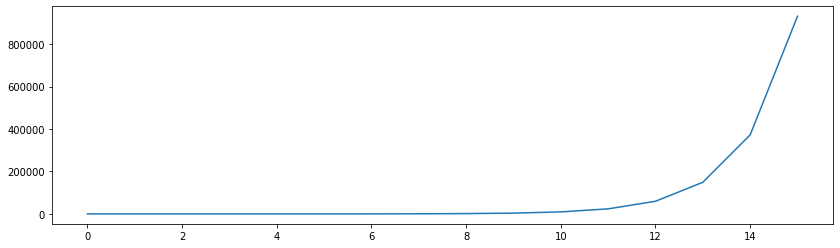

In [14]:
plt.plot(contagion(2.5, 16));

The actual infectiousness of SARS-CoV-2, however, is not concentrated in a single day but follows a curve that rises and falls with the duration of the sickness, as shown in this figure ([source](https://medium.com/@tomaspueyo/coronavirus-the-hammer-and-the-dance-be9337092b56)):

![title](covid.png)

We can model this with an IIR filter with a longer feedback loop like so:

In [15]:
def covid(N):
    h = np.array([1, -.1, -.15, -.25, -.26, -.34, -.42, -.25, -.2, -.15, -.1, -.1, -.1])
    return sp.lfilter([1], h, np.r_[1, np.zeros(N-1)])

and we can see that, with this less aggressive pattern, the number of newly infected people per day grows much more slowly at first...

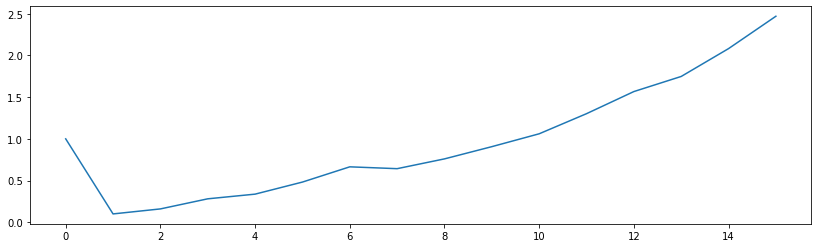

In [16]:
plt.plot(covid(16));

... but the exponential trend is there and it will inexorably lead to disaster: it will take 140 days but in the end we will reach the million mark.

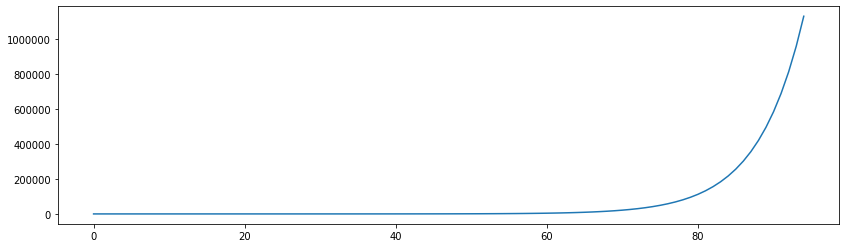

In [20]:
plt.plot(covid(95));

The idea of social distancing is predicated on the fact that $R_0$ is proportional to the number of encounters of a sick individual. By reducing the latter, we implicitly reduce the overall reproduction number. Let's assume that we can reduce the social interaction of every individual by a factor $q_f$:

In [16]:
def covid_q(N, qf):
    h = qf * np.array([1/qf, -.1, -.15, -.25, -.26, -.34, -.42, -.25, -.2, -.15, -.1, -.1, -.1])
    return sp.lfilter([1], h , np.r_[1, np.ones(N-1)])

With this, let's look at the how many new infections per day we have after 140 days: with a reduction of social activity by 25% we have this

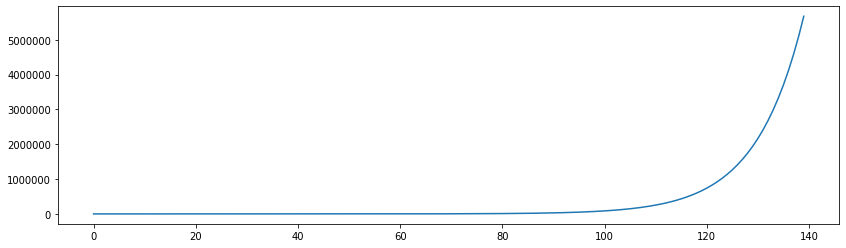

In [17]:
plt.plot(covid_q(140, 0.75));

Whereas by reducing social contact by 50% we have this:

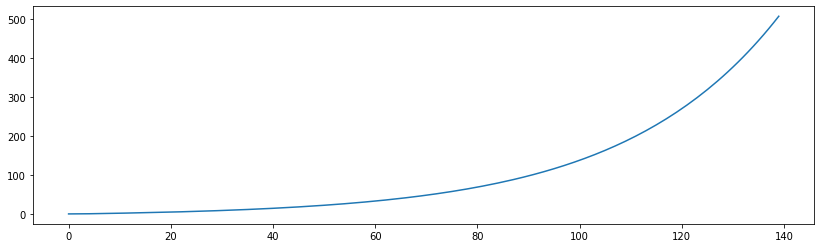

In [18]:
plt.plot(covid_q(140, 0.5));

Of course the trends are still exponential, but this slower growth rate is what buys us "time" to act on the infrastructure of the health care system and on the research for new therapies.